First, load the package and instantiate the dependencies.

In [1]:
using Pkg
pkg"activate .; instantiate; precompile" # may take a long time the first time this is run

Activating environment at `~/Research/packages/PerlaTonettiWaugh.jl/Project.toml`
Precompiling project...


And load the deps

In [2]:
using CSV, Plots, JSON, BenchmarkTools, Parameters, PerlaTonettiWaugh, DataFrames, Suppressor
gr(fmt = :png)

┌ Info: Precompiling Suppressor [fd094767-a336-5f1f-9728-57cf17d0bbfb]
└ @ Base loading.jl:1273


Plots.GRBackend()

## Stationary Solutions

First, define common objects for the full model

In [3]:
parameters = parameter_defaults(); # model parameters
settings = settings_defaults(); # numerical solution settings
settings_rough = settings_defaults(z_ex = unique([range(0., 0.1, length = 50); range(0.1, 1., length = 20); range(1., 5, length = 10)]),
                            tstops = unique([range(0.0, 10.0, length=20); range(10.0, 20.0, length=20); range(20.0, (settings_defaults().T), length=50)]));

# DISABLE THE FOLLOWING LINE TO GET THE FULL SOLUTION
settings = settings_rough;

To solve for time 0 and ``T`` stationary solutions, simply:

In [4]:
@unpack stationary_T, stationary_0, change_welfare, change_trade = compare_steady_states(parameters, settings);

We can inspect each:

In [5]:
@show (stationary_0.g, stationary_0.z_hat, stationary_0.Ω, stationary_0.L_tilde)

(stationary_0.g, stationary_0.z_hat, stationary_0.Ω, stationary_0.L_tilde) = (0.009406132836676406, 1.9819210575181363, 0.9532758888421309, 0.24113093943661773)


(0.009406132836676406, 1.9819210575181363, 0.9532758888421309, 0.24113093943661773)

And

In [6]:
@show (stationary_T.g, stationary_T.z_hat, stationary_T.Ω, stationary_T.L_tilde)

(stationary_T.g, stationary_T.z_hat, stationary_T.Ω, stationary_T.L_tilde) = (0.011490746933411435, 1.8441321908826385, 0.9020186133615725, 0.2459927396535116)


(0.011490746933411435, 1.8441321908826385, 0.9020186133615725, 0.2459927396535116)

And display the other objects:

In [7]:
@show change_welfare;

change_welfare = 8.872613640962346


In [8]:
@show change_trade;

change_trade = 0.03795109338584812


## Autarky

Let's also define and inspect the autarky steady state

In [9]:
# Solve for the autarky case
defaults = parameter_defaults()
params_autarky = merge(defaults, (d_T = 1 + (defaults.d_0-1)*2.5,))

autarky_results = compare_steady_states(params_autarky, settings, verbose = true);
# quantities we need for later analysis
stationary_autarky = autarky_results.stationary_T;
lambda_ss_autarky = autarky_results.change_welfare;

SS to SS welfare gain: -16.948681676953825
Change in Trade: -0.10034260085683033
Growth Rates across SS: 0.47397280999823327 (time T) vs 0.9406132836676406 (time 0)


## Transition Dynamics

The code is

In [10]:
cachename = model_cachename(parameters, settings) # uniquely identify the run by parameters + settings
cachepath = joinpath(pwd(), "data", cachename * ".csv")
use_cache = true # change this to false if you don't want to use the cache for a run
write_cache = true # change this to false if you don't want to generate *any* cache files for a run

# reading
if isfile(cachepath) && use_cache
    println("using cache.")
    solved = CSV.read(cachepath);
else
    println("solving without cache.")
    @time solution = @suppress solve_transition(parameters, settings);
    solved = solution.results 
end

# writing
if write_cache
    mkpath(joinpath(pwd(), "data")) # if this doesn't eist for whatever reason
    CSV.write(cachepath, solved) # write DataFrame
    write(joinpath(pwd(), "data", cachename * ".json"), JSON.json((parameters = parameters, settings = merge(settings, (interp = typeof(settings.interp), stationary_x0 = typeof(settings.stationary_x0), fixedpoint_x0 = typeof(settings.fixedpoint_x0) ))))) # write parameters
else
    # nothing
end

filter!(row -> row.t >= 0, solved) # don't plot pre-shock values

solving without cache.
1646.351678 seconds (1.52 G allocations: 156.892 GiB, 1.11% gc time)


,t,g,z_hat,Ω,E,v_1,L_tilde,entry_residual
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0106106,1.86403,0.953276,0.0148177,4.93572,0.224806,0.0
2,0.526316,0.0105978,1.86434,0.953255,0.0148946,4.93572,0.225153,0.0
3,1.05263,0.0105861,1.86462,0.953191,0.0149729,4.93572,0.225506,0.0
4,1.57895,0.0105755,1.86487,0.953087,0.0150525,4.93572,0.225863,0.0
5,2.10526,0.0105659,1.8651,0.952943,0.0151332,4.93572,0.226225,0.0
6,2.63158,0.0105574,1.86531,0.952762,0.015215,4.93572,0.22659,0.0
7,3.15789,0.01055,1.86549,0.952544,0.0152977,4.93572,0.226959,0.0
8,3.68421,0.0105435,1.86565,0.952292,0.0153814,4.93572,0.227331,0.0
9,4.21053,0.0105379,1.86578,0.952006,0.0154658,4.93572,0.227706,0.0


## Welfare

Here's welfare inclusive of the transition path:

In [11]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_0.U_bar, parameter_defaults())-1);
@show lambda_tpath;

lambda_tpath = 9.091664462327342


## Plots

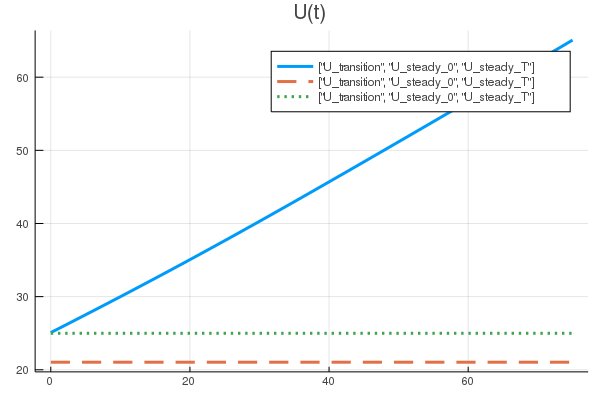

In [12]:
U_steady_0(t) = stationary_0.U_bar
U_steady_T(t) = stationary_T.U_bar

plot(solved.t,
   [solved.U, U_steady_0, U_steady_T],
   label = ["U_transition", "U_steady_0", "U_steady_T"] ,
   title = "U(t)", linestyle = :auto, lw = 3)

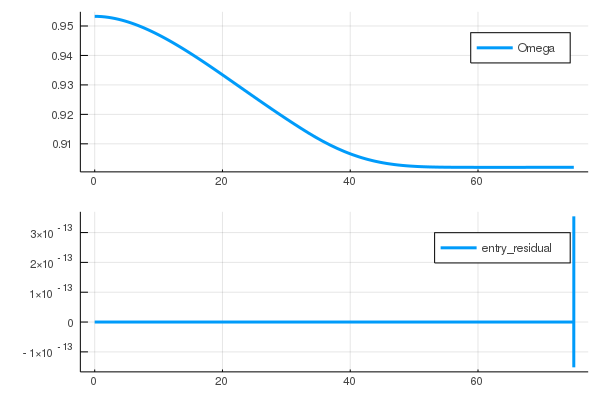

In [13]:
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

Here are the static equations

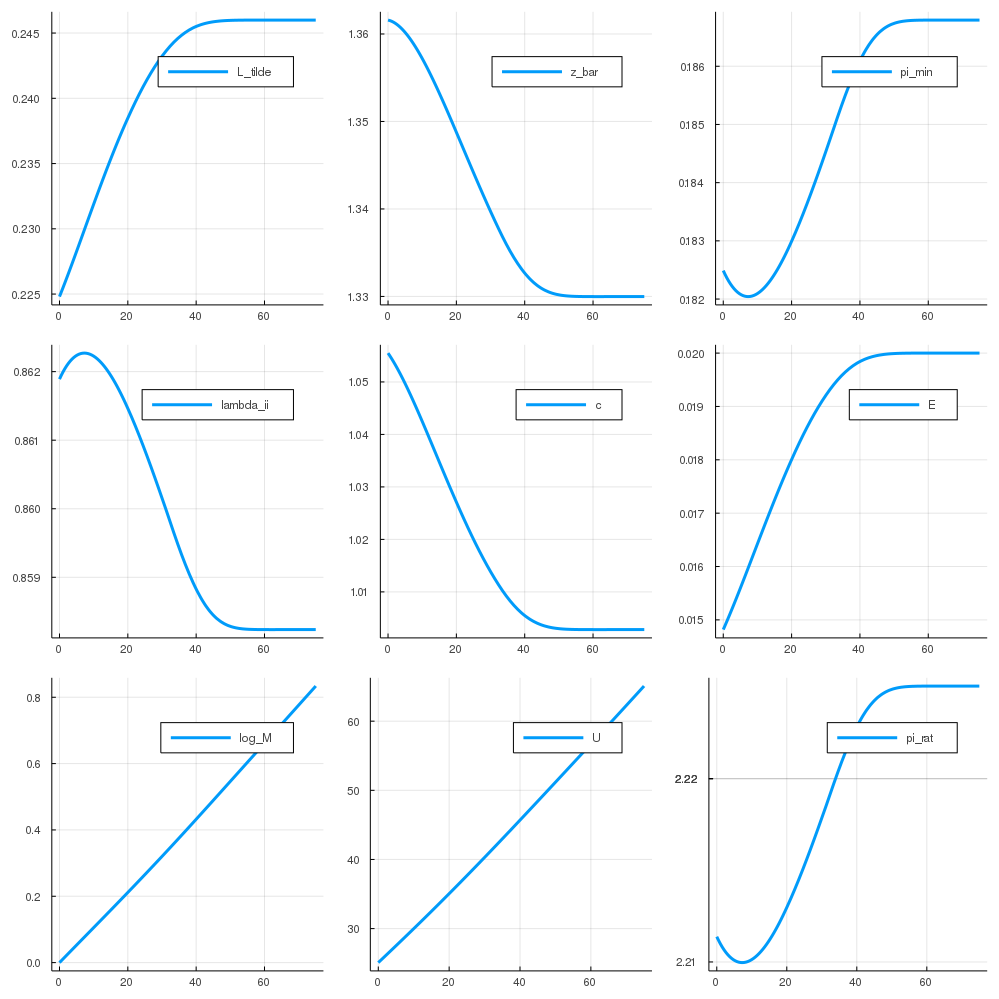

In [14]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(solved.t, solved.π_rat, label = "pi_rat", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, layout=(3,3), size = (1000, 1000))

And a more granular look at welfare

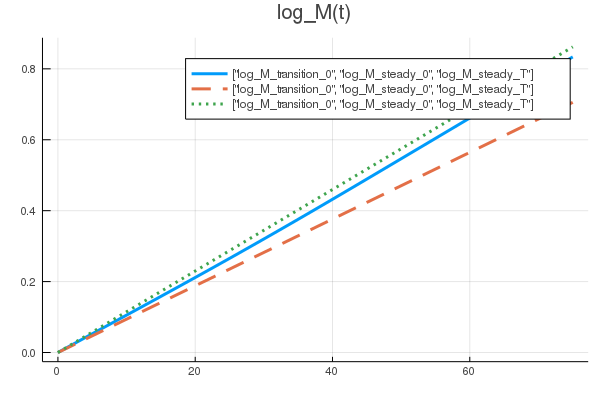

In [15]:
log_M_steady_0(t) = stationary_0.g * t
log_M_steady_T(t) = stationary_T.g * t

plot(solved.t,
    [solved.log_M, log_M_steady_0, log_M_steady_T],
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

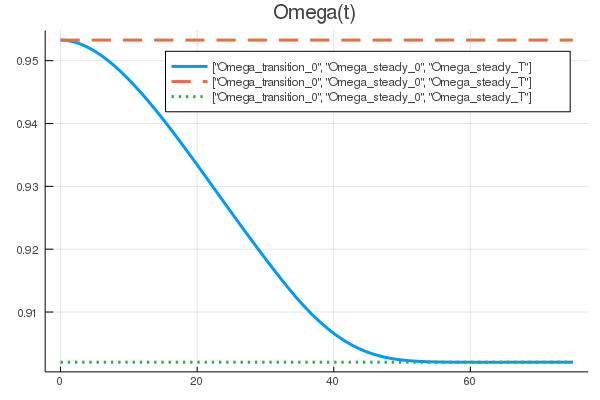

In [16]:
Ω_steady_0(t) = stationary_0.Ω
Ω_steady_T(t) = stationary_T.Ω

plot(solved.t,
    [solved.Ω, Ω_steady_0, Ω_steady_T],
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

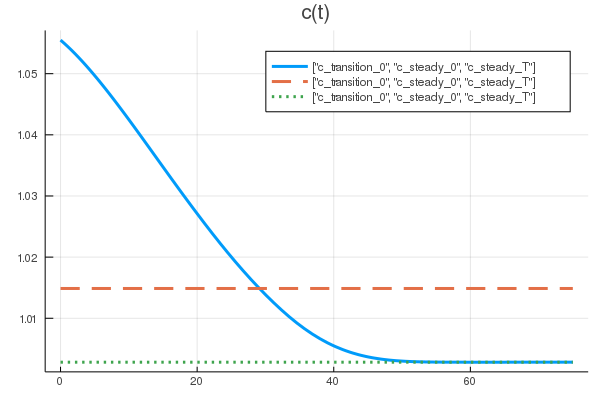

In [17]:
c_steady_0(t) = stationary_0.c
c_steady_T(t) = stationary_T.c

plot(solved.t,
    [solved.c, c_steady_0, c_steady_T],
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

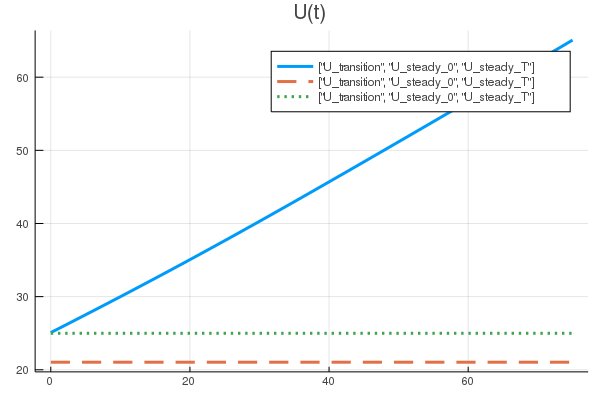

In [18]:
U_steady_0(t) = stationary_0.U_bar
U_steady_T(t) = stationary_T.U_bar

plot(solved.t,
    [solved.U, U_steady_0, U_steady_T],
    label = ["U_transition", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

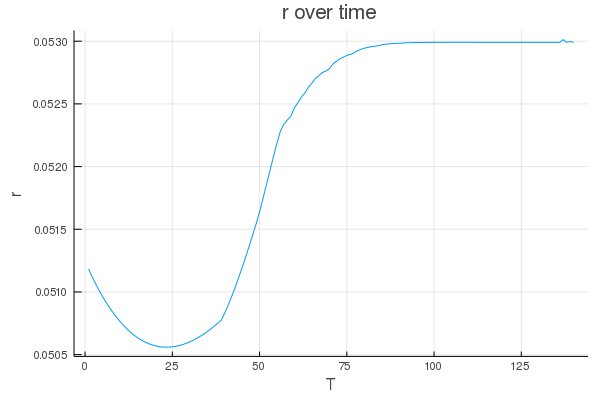

In [19]:
plot(solved.r, legend = false, title = "r over time", xlabel = "T", ylabel = "r")

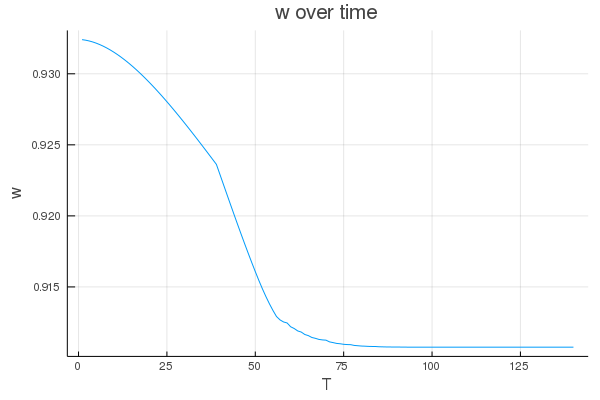

In [20]:
plot(solved.w, legend = false, title = "w over time", xlabel = "T", ylabel = "w")

Here's the labor share breakdown

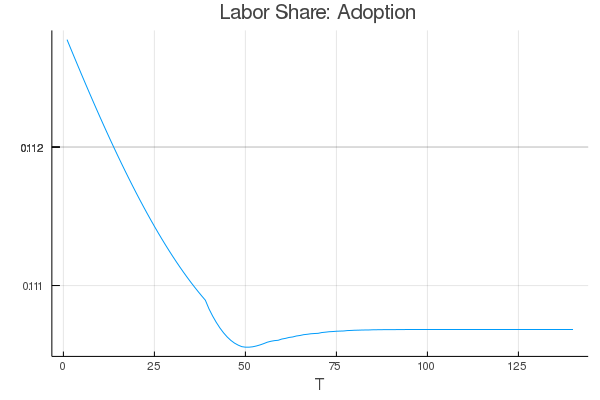

In [21]:
plot(solved.L_tilde_a, legend = false, xlabel = "T", title = "Labor Share: Adoption")

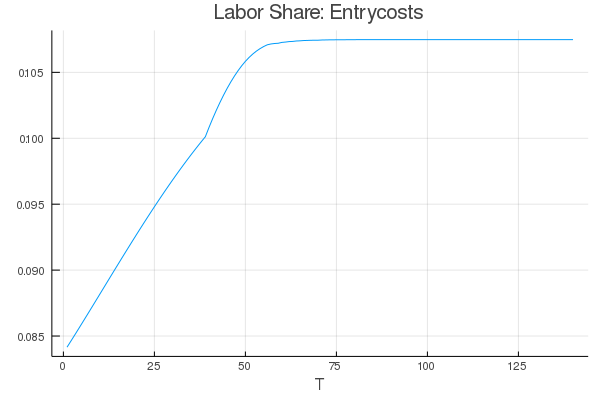

In [22]:
plot(solved.L_tilde_E, legend = false, xlabel = "T", title = "Labor Share: Entrycosts")

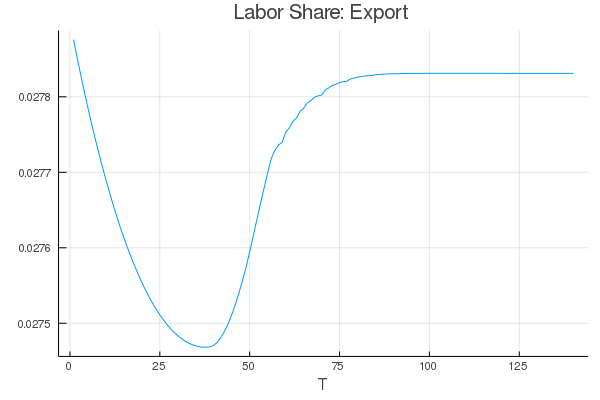

In [23]:
plot(solved.L_tilde_x, legend = false, xlabel = "T", title = "Labor Share: Export")

And the consumption equivalent

In [24]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_0.U_bar, parameter_defaults())

1.0909166446232734

## Writing Data

Save welfare and autarky dataframes.

In [25]:
df_welfare = DataFrame(steady_state = change_welfare, transition_path = lambda_tpath, growth_rate = stationary_T.g, theta = parameter_defaults().θ);
write_cache && CSV.write("data/welfare_results-" * cachename * ".csv", df_welfare)

"data/welfare_results-17634630414446196711.csv"

In [26]:
df_autarky = DataFrame(steady_state = lambda_ss_autarky, growth_rate = stationary_autarky.g, theta = parameter_defaults().θ);
write_cache && CSV.write("data/autarky_results-" * cachename * ".csv", df_autarky)

"data/autarky_results-17634630414446196711.csv"